### Research on video game sales  

<div class="alert alert-info" role="alert">

We work for the online store Ice, which sells video games all over the world. In front of us is data going back to 2016. Let’s imagine that it’s December 2016 and we’re planning a campaign for 2017. We are going to identify patterns that determine whether a game succeeds or not. This will allow us to spot potential big winners and plan advertising campaigns.
</div>

# Table of contents

1. [Step 1: Open the data file and study the general information](#introduction)
2. [Step 2: Prepare the data](#paragraph1)
4. [Step 3: Analyze the data](#paragraph2)
5. [Step 4: Create a user profile for each region](#paragraph3)
6. [Step 5: Testing of hypotheses](#paragraph4)
7. [Step 6: General conclusion](#paragraph5)












## Step 1: Open the data file and study the general information

<a class="anchor" id="introduction"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import requests
import scipy.stats as st
from scipy import stats
from scipy.stats import bartlett

import warnings
warnings.filterwarnings('ignore')

In [4]:
df1 = pd.read_csv("/datasets/games.csv")

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
report = df1.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = ((report['missing_values'] / df1.shape[0]).round(2))* 100
report.sort_values(by = 'missing_values', ascending = False)
report

,missing_values,% of total
Name,2,0.0
Platform,0,0.0
Year_of_Release,269,2.0
Genre,2,0.0
NA_sales,0,0.0
EU_sales,0,0.0
JP_sales,0,0.0
Other_sales,0,0.0
Critic_Score,8578,51.0
User_Score,6701,40.0


In [4]:
df1.tail(10)

In [8]:
print(df1["Year_of_Release"].min())

print(df1["Year_of_Release"].max())

print(df1[df1["Year_of_Release"] == 1980])

1980.0
2016.0
                 Name Platform  Year_of_Release     Genre  NA_sales  EU_sales  \
262         Asteroids     2600           1980.0   Shooter      4.00      0.26   
546   Missile Command     2600           1980.0   Shooter      2.56      0.17   
1764          Kaboom!     2600           1980.0      Misc      1.07      0.07   
1968         Defender     2600           1980.0      Misc      0.99      0.05   
2650           Boxing     2600           1980.0  Fighting      0.72      0.04   
4019       Ice Hockey     2600           1980.0    Sports      0.46      0.03   
5360          Freeway     2600           1980.0    Action      0.32      0.02   
6300           Bridge     2600           1980.0      Misc      0.25      0.02   
6875         Checkers     2600           1980.0      Misc      0.22      0.01   

      JP_sales  Other_sales  Critic_Score User_Score Rating  
262        0.0         0.05           NaN        NaN    NaN  
546        0.0         0.03           NaN        Na

### Step 1: Conclusion

The dataset looks like a "normal" table (we don't need to use "sep" or "decimal" parameter of _read_csv()_ function, which were introduced in our theory chapter).

As we can see in the output, we have a lot of work to do with the data, namely: 

- some data is missing (e.g. only 8137 row in _Critic_Score_ column, only 9949 in _Rating_ column etc., we can see NaN); we have to check, if we can to fill in the missing data. 

- some of datatypes do not suits the saved data (e.g. float64 for year _Age_ column etc.). We have to handle it. 

- Sales data are also saved as floats in USD millions, we can save used memory if we recalculate all the figurs in dollars and convert the same information into intergers. But we are not going to do it as far we are working with 1.4 Mb size dataset. 

- we also don't see any duplicates in the _head()_ method output, but we have to check it more precisely and (if necessary) to handle it.

## Step 2: Prepare the data
<a class="anchor" id="paragraph1"></a>

In [10]:
df1.columns = map(str.lower, df1.columns)

In [11]:
df1['year_of_release']=df1['year_of_release'].fillna(0)

df1['year_of_release']=df1['year_of_release'].astype('int16')

In [8]:
df.info()

We made the column names lowcase according to python style guide. 

At this place we converted the _year_ column into _int16_ only, because it was just impossible to tolerate float64 for saving of years :-) (_We have to explain why: because it makes no sence to save years as floating point numbers. _Int16_ uses 4 times less memory for storage the same amount information._ ) (We are going to make some more changes later.)

As we mentioned earlier, all the _ _sales_ columns can be recalculated to integers too, but it is not mandatory. As well as _critic_score/critic_score_ could be converted to int8 to save memory, but we preffer to have floats here for more accuracy. 

Let's see, what we can do with missing values. 

In [9]:
print(df1[df1["name"].isnull()])

We have two games without names. All we know about it, they we released 1993 for GEN platform and it's sales data. We are going just to drop this two rows. 

In [12]:
df1 = df1[df1['name'].notna()]

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int16
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(5), int16(1), object(5)
memory usage: 1.4+ MB


We have a lot of missing values in last three columns. We do not know the exactly reason, why this data is missing. 

It can be due a some kind of technical error during data collection/storage/extracting/preprocessing. 

Or it also can be, that this rating/score data was not collected. It can occur e.g. in case, if a film has no critic/user votes. It's pretty obvious, that in this case a critic/user score can not be calculated.  

Values in the _rating_ column seems to be entered manually, and this type of data collections garantees a lot of errores and missing data. 

We also have a lot of "TBD" entries in the  _user_score_ column. This signals, that this data should be fill in later; but it didn't happen. In this case the entries are equal to NaNs. We are going to substitute it and try to fill in this values just as regular missing values. 

In [14]:
df1['user_score'] = df1['user_score'].str.replace('tbd', '0')

In [13]:
df1['user_score']=df1['user_score'].astype('float64')
df1.info()

In [14]:
df1.replace(0, np.nan, inplace=True)

We replaced all the tbd's by NaNs to handle it together with other NaNs later.

In [15]:
print(len(df1[df1['user_score'] == "tbd"]))

There are too many of missing data to just drop it. We are going to fill in some missing values using data from another dataset (https://www.kaggle.com/jummyegg/rawg-game-dataset, the link was provided by our tutor). 

We selected on our local PC a few columns from the dataset and imported it via Google.Drive to our Notebook as dataframe _df3_. 

In [15]:
spreadsheet_id = '11MoW0r4-IV56xbefE8sQcOnmQNjwpgFM-C44emg83QQ'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id) 
r = requests.get(file_name)
df3 = pd.read_csv(BytesIO(r.content))
df3


,Unnamed: 0,name,released,rating,esrb_rating,metacritic
0,0,D/Generation HD,2015-10-23,0.0,Everyone 10+,NaN
1,1,G Prime Into The Rain,2016-01-06,0.0,Everyone,NaN
2,2,Land Sliders,2015-09-24,0.0,Everyone 10+,NaN
3,3,Pixel Gear,2016-10-20,0.0,Teen,NaN
4,4,Gods and Idols,2016-12-12,0.0,NaN,NaN
...,...,...,...,...,...,...
474412,474412,Holy or Dead,2017-05-17,0.0,NaN,NaN
474413,474413,Airstrike HD Demo,2016-03-04,0.0,NaN,NaN
474414,474414,Urania's Mirror,2016-04-25,0.0,NaN,NaN
474415,474415,Simucities,2017-05-26,0.0,NaN,NaN


We have to preprocess the data a bit and rename columns to distinguish data from both datasets after merging. 

In [16]:
df3['released'] = df3['released'].astype("datetime64")
df3['released'] = df3['released'].dt.year

df3['released'] = df3['released'].fillna(0)

df3['released'] = df3['released'].astype("int16")

In [17]:
df3['user_rating'] = df3['rating']
df3['critic_rating'] = df3['metacritic']

In [19]:
df1.info()

In [20]:
df3.info()

In [48]:
df = pd.merge(df1,
                 df3[['name', 'released', 'user_rating', 'critic_rating', 'esrb_rating']],
                 on='name', how='left')
df.head()
        

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,released,user_rating,critic_rating,esrb_rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,2006.0,4.19,76.0,NaN
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,1985.0,4.27,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,2008.0,4.26,82.0,NaN
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,2009.0,4.17,80.0,Everyone
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16712
Data columns (total 15 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           12206 non-null float64
eu_sales           10844 non-null float64
jp_sales           6200 non-null float64
other_sales        10113 non-null float64
critic_score       8137 non-null float64
user_score         7589 non-null float64
rating             9949 non-null object
released           9820 non-null float64
user_rating        9820 non-null float64
critic_rating      2346 non-null float64
esrb_rating        3448 non-null object
dtypes: float64(10), object(5)
memory usage: 2.0+ MB


And now we are going to try to fill the missing values in columns _critic_score, user_score, rating, year_of_release_ 

In [19]:
print(len(df[df['critic_score'].isnull()]))
print(len(df[df['user_score'].isnull()]))
print(len(df[df['rating'].isnull()]))
print(len(df[df['year_of_release'] == 0.0]))

8576
6699
6764
269


In [20]:
df3.sample(10)

,Unnamed: 0,name,released,rating,esrb_rating,metacritic,user_rating,critic_rating
11068,11068,secant remix,2017,0.00,NaN,NaN,0.00,NaN
29669,29669,The Penanggalan,2015,0.00,NaN,NaN,0.00,NaN
445202,445202,Highscore Processing Unit,2018,0.00,NaN,NaN,0.00,NaN
392054,392054,Captain Food,2020,0.00,NaN,NaN,0.00,NaN
325374,325374,Gala Collider,2020,0.00,NaN,NaN,0.00,NaN
194445,194445,Darkness and Flame: Born of Fire (Full),2016,0.00,NaN,NaN,0.00,NaN
355236,355236,Zellda,2017,0.00,Everyone 10+,NaN,0.00,NaN
249314,249314,Farmship: TriPeaks Solitaire,0,0.00,Everyone,NaN,0.00,NaN
472099,472099,SokobanCoon,2017,0.00,NaN,NaN,0.00,NaN
267330,267330,Pro Evolution Soccer 6,2006,4.41,NaN,NaN,4.41,NaN


In [49]:
df['critic_score'] = df.critic_score.fillna(df.critic_rating)
df['user_score'] = df.user_score.fillna(df.user_rating)
df['rating'] = df.rating.fillna(df.esrb_rating)
#df['year_of_release'] = df.year_of_release.replace(0, np.nan).fillna(df.released)

In [22]:
print(len(df[df['critic_score'].isnull()]))
print(len(df[df['user_score'].isnull()]))
print(len(df[df['rating'].isnull()]))
print(len(df[df['year_of_release']== 0]))

8227
4239
6270
269


In [50]:
df.drop(['released', 'user_rating', 'critic_rating', 'esrb_rating'], axis=1, inplace=True)

df.info()

As we can see in the output, we filled in hundreds/thousands of missed values (depends from the column). 

Let's check, what we get after filling in. Maybe something went wrong?

In [51]:
print(df.rating.unique())
print()
print(df.critic_score.unique())
print()
print(df.user_score.unique())

['E' nan 'M' 'T' 'E10+' 'Everyone' 'Everyone 10+' 'Teen' 'Mature' 'K-A'
 'AO' 'Adults Only' 'EC' 'Rating Pending' 'RP']

[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 67. 99. 49. 81. 66. 56.
 79. 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65.
 54. 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 35. 41.
 36. 28. 31. 27. 26. 19. 23. 24. 21. 17. 22. 13.]

['8' 4.27 '8.3' nan '8.5' '6.6' '8.4' 0.0 '8.6' '7.7' '6.3' '7.4' '8.2'
 '9' 4.41 '7.9' 3.92 4.38 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9'
 '6.4' '7.8' 4.46 4.34 '7.5' 4.3 '2.6' '7.2' '9.2' '7' '7.3' 4.39 4.05
 '4.3' '7.6' 3.35 4.11 '5.7' '5' '9.1' 3.87 '6.5' 4.17 '0' '8.8' 3.26 4.13
 '6.9' 4.36 '9.4' '6.8' '6.1' 4.15 3.94 '6.7' 4.07 '5.4' 3.84 4.03 4.35
 '4' 4.14 4.19 4.37 3.21 '4.9' '4.5' '9.3' '6.2' '4.2' 3.38 4.33 '6' 3.83
 '3.7' 4.47 3.62 3.33 4.31 4.32 4.29 4.0 3.71 4.12 '4.1' '5.8' '5.6' 3.64
 '5.5' '4.4' '4.6' '5.9'

_critic_score_ and _user_score_ look very realistic. 

At the same time, it's pretty obviouse, that in the _rating_ column 'Everyone' == 'E', 'E10+' == 'Everyone 10+', 'M' == 'Mature', 'AO' == 'Adults Only', 'T' == 'Teen', 'Rating Pending' == 'RP'. 

Let's handle it.

In [29]:
df.rating.value_counts()

In [52]:
df['rating'] = df['rating'].map({'Everyone 10+':'E10+', 'E10+': 'E10+','Everyone': 'E', 'E': 'E', "Mature": "M", "M": "M", "Adults Only": "AO", "AO": "AO", "Teen": "T", "T": "T", "Rating Pending": "Other","RP": "Other"})

In [31]:
df.rating.value_counts()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int16
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8486 non-null float64
user_score         12474 non-null object
rating             10432 non-null object
dtypes: float64(5), int16(1), object(5)
memory usage: 1.4+ MB


In [99]:
df['user_score']=df['user_score'].astype('float64')

We still have a lot of missing values and grouping won't simply work in this case. That's why we are going just to replace the rest of NaNs by zeros. This give us a possibility to make further calculations. (In real life we would preffer to ask a person how gave us the data about this data.)

_**Later remark**: at first we also get the missing **year_of_release** values from the new dataset, but during the analysis phase we founded out, that in this case the merging was not so smooth: e.g. we got a few PS2 games released in 1990s and many 2600 games released allegedly in 2012, what is  apparently can not be true. So we just dropped this 200+ rows where we do not know the release year._

In [53]:
df = df[df['year_of_release'] != 0]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16712
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int16
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       8327 non-null float64
user_score         12253 non-null object
rating             10246 non-null object
dtypes: float64(5), int16(1), object(5)
memory usage: 1.4+ MB


In [54]:
df = df.fillna(0)

#df['year_of_release']=df['year_of_release'].astype('int16')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16712
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int16
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null float64
user_score         16444 non-null object
rating             16444 non-null object
dtypes: float64(5), int16(1), object(5)
memory usage: 1.4+ MB


In [55]:
df.rating = df.rating.replace(0, "Unknown")
print(df.rating.unique())

['E' 'Unknown' 'M' 'T' 'E10+' 'AO' 'Other']


Let's calculate the total sales (the sum of sales in all regions) for each game and put these values in a separate column.

In [56]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16712
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int16
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null float64
user_score         16444 non-null object
rating             16444 non-null object
total_sales        16444 non-null float64
dtypes: float64(6), int16(1), object(5)
memory usage: 1.5+ MB


In [39]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,4.27,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0,Unknown,31.38


### Step 2: Conclusion

We had done a really huge work in this step.

We preprocessed our dataset: we replaced the column names (made them lowercase); converted the data to the required types where it was nessecary. 

We also got rid of all "tbd" entries in the _user_score_ column. Strings has no place in the numerical column. 

We merged our dataset with another, bigger one to fill in thousands of missing values. To do so we imported the second dataset to Yandex practicum platform via Google.Drive, preprocessed dataset locally and on the platform.

We get rid of duplucates in the _rating_ column and a few untrustworthy rows based on the year of release. 

Unfortunatly it was not possible to fill in _all_ the missing values. The entries we couldn't fill in we replayced by zeros(or by "Other" in case of _rating_). We are going to keep it in mind during further calculations/analysis. 

Finally we calculated the total sales (the sum of sales in all regions) for each game and put these values in a separate column. 

## Step 3: Analyze the data

Let's analyze the data! At first we are looking at how many games were released in different years and if the data for every period significant?

In [40]:
print(df.groupby('year_of_release').size())

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
dtype: int64


The output is very interesting: it shows all the main information about history of the game industry: the first launch around 1980, a very few releases in 1980s and early 1990s, the fast and continiuos growing starting in 1993-1994, the peak in 2008-2009, and stable 500-600 releases in 2012-2016. 

So we get all the historical periods of the industry with just one line of code, ant it's very significant information which'll help us in our further analysis. 

In [57]:
len(df.platform.unique())

31

In [58]:
platforms_stat = df.groupby('platform')[['total_sales']].sum().join(
    df.groupby('platform')[['name']].count())
platforms_stat.columns = ['total_sales', 'number_of_games']
platforms_stat.sort_values('total_sales', ascending=False, inplace=True)

platforms_stat = platforms_stat.reset_index()

print(platforms_stat.head(31))

   platform  total_sales  number_of_games
0       PS2      1233.56             2127
1      X360       961.24             1232
2       PS3       931.34             1306
3       Wii       891.18             1286
4        DS       802.78             2121
5        PS       727.58             1190
6       PS4       314.14              392
7       GBA       312.88              811
8       PSP       289.53             1193
9       3DS       257.81              512
10       PC       255.76              957
11       GB       254.43               97
12       XB       251.57              803
13      NES       251.05               98
14      N64       218.01              316
15     SNES       200.04              239
16       GC       196.73              542
17     XOne       159.32              247
18     2600        86.48              116
19     WiiU        82.19              147
20      PSV        53.81              429
21      SAT        33.59              173
22      GEN        28.35          

In the output we can see, how sales varied from platform to platform: the most sales were generated by PS2, X360, PS3 and Wii. The total revenue of PS2 is over 1.255 billion dollars! 

X360, PS3 and Wii collected almost one billion dollars each. 

There were a lot of other polular platforms. 

In [59]:
years_df = df.groupby(['platform', 'year_of_release'])[['total_sales']].sum().join(
    df.groupby('year_of_release')[['name']].count())

years_df.columns = ['total_sales', 'number_of_games']

years_df = years_df.reset_index()
print(years_df.tail(20))

    platform  year_of_release  total_sales  number_of_games
218     X360             2010       170.03             1255
219     X360             2011       143.84             1136
220     X360             2012        99.74              653
221     X360             2013        88.58              544
222     X360             2014        34.74              581
223     X360             2015        11.96              606
224     X360             2016         1.52              502
225       XB             2000         0.99              350
226       XB             2001        22.26              482
227       XB             2002        48.01              829
228       XB             2003        55.04              775
229       XB             2004        65.42              762
230       XB             2005        49.08              939
231       XB             2006        10.04             1006
232       XB             2007         0.55             1197
233       XB             2008         0.

In the table we created in the next cell we can find a distribution for each platform based on data for each year. 

Let's see the paticular information for some of the platforms.

In [60]:
platforms = platforms_stat["platform"].unique().tolist()

for platform in platforms: 
    print(years_df[years_df["platform"] == platform])

    platform  year_of_release  total_sales  number_of_games
130      PS2             2000        39.17              350
131      PS2             2001       166.43              482
132      PS2             2002       205.38              829
133      PS2             2003       184.31              775
134      PS2             2004       211.81              762
135      PS2             2005       160.66              939
136      PS2             2006       103.42             1006
137      PS2             2007        75.99             1197
138      PS2             2008        53.90             1427
139      PS2             2009        26.40             1426
140      PS2             2010         5.64             1255
141      PS2             2011         0.45             1136
    platform  year_of_release  total_sales  number_of_games
213     X360             2005         8.25              939
214     X360             2006        51.62             1006
215     X360             2007        95.

So we can see, that the leading platforms generate a solid revenue from the very first year arter release. But typically it grows significantly after 1-3 years, then we see a flattening of the curve for a 2-4 years, and after peak time usually it fades during 3-6 years. Therefore the average lifetime is typically less than 10 years.

As platforms used to be popular but now have zero sales we can name e.g. PS2, PS, DS, GBA etc. 

There are also some platforms _from well-known producers_ which made a great sales already in the very first year after release (e.g. Wii, 3DS, N64, SNEC etc.)

In [69]:
df = df[df['year_of_release'] >= 2013]

In [62]:
df.shape

(2233, 12)

In [70]:
 print(df.platform.unique())

['PS3' 'X360' 'PS4' '3DS' 'XOne' 'WiiU' 'Wii' 'PC' 'PSV' 'DS' 'PSP']


In [67]:
platforms_stat2 = df.groupby('platform')[['total_sales']].sum().join(
    df.groupby('platform')[['name']].count())
platforms_stat2.columns = ['total_sales', 'number_of_games']
platforms_stat2.sort_values('total_sales', ascending=False, inplace=True)

platforms_stat2 = platforms_stat2.reset_index()

print(platforms_stat2.head(11))

   platform  total_sales  number_of_games
0       PS4       314.14              392
1       PS3       181.43              345
2      XOne       159.32              247
3       3DS       143.25              303
4      X360       136.80              186
5      WiiU        64.63              115
6        PC        39.43              189
7       PSV        32.99              358
8       Wii        13.66               23
9       PSP         3.50               67
10       DS         1.54                8


In [71]:
years_df = years_df[years_df['year_of_release'] >= 2013]

platforms2 = platforms_stat2["platform"].unique().tolist()

for platform in platforms2: 
    print(years_df[years_df["platform"] == platform])

    platform  year_of_release  total_sales  number_of_games
153      PS4             2013        25.99              544
154      PS4             2014       100.00              581
155      PS4             2015       118.90              606
156      PS4             2016        69.25              502
    platform  year_of_release  total_sales  number_of_games
149      PS3             2013       113.25              544
150      PS3             2014        47.76              581
151      PS3             2015        16.82              606
152      PS3             2016         3.60              502
    platform  year_of_release  total_sales  number_of_games
234     XOne             2013        18.96              544
235     XOne             2014        54.07              581
236     XOne             2015        60.14              606
237     XOne             2016        26.15              502
   platform  year_of_release  total_sales  number_of_games
14      3DS             2013        56.57

   
If we concider data for 2013-2016 only, we get another platforms in the Top 5: PS4, PS3, XOne, 3DS, WiiU. 

As we know, PS3 was released in 2006 and threfore is already at an age when sales are only going down. The other four platforms are newer and stil actual. PS4, XOne and WiiU seem to be in their best shape. (we remember, that our data for 2016 are not complete!)  
    
With 3DS we can not be sure: althogh the platform is young, its' sales are continiously falling since 2014. 

Therefore potentially profitable in 2017 platforms are PS4, XOne and WiiU. The 3DS is also relativly young, but we would not recommend to promote it because its sales are continiously falling. 

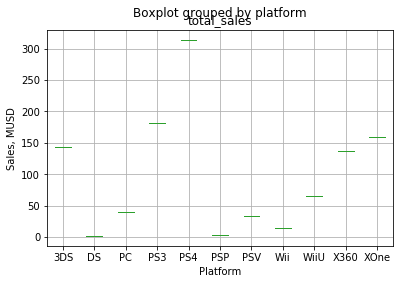

In [72]:
platforms_stat2.boxplot(column = "total_sales", by = "platform")

#plt.title('Total sales by a platform')
plt.xlabel('Platform')
plt.ylabel('Sales, MUSD');

The difference is significant: only a few platforms has a total sales level around 1MM USD, a bit more platforms has a total sales level 50-350M USD, and there are 4 platforms with very low sales level. 

In [83]:
ps4 = df[df["platform"] == "PS4"]

print(len(ps4))

ps4 = ps4[ps4["user_score"] !=0 ]
ps4 = ps4[ps4["critic_score"] !=0 ]

ps4['user_score'] = ps4['user_score'].astype('float64')

print(ps4.info())

print(len(ps4))


392
<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 42 to 16528
Data columns (total 12 columns):
name               277 non-null object
platform           277 non-null object
year_of_release    277 non-null int16
genre              277 non-null object
na_sales           277 non-null float64
eu_sales           277 non-null float64
jp_sales           277 non-null float64
other_sales        277 non-null float64
critic_score       277 non-null float64
user_score         277 non-null float64
rating             277 non-null object
total_sales        277 non-null float64
dtypes: float64(7), int16(1), object(4)
memory usage: 26.5+ KB
None
277


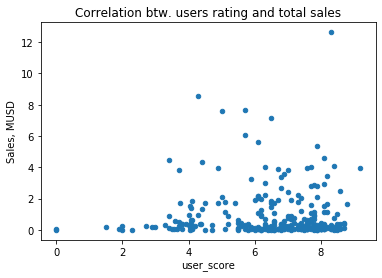

In [84]:
ps4.plot(x='user_score',y='total_sales', kind ='scatter')

plt.title('PS4: correlation btw. users rating and total sales')
#plt.xlabel('Us')
plt.ylabel('Sales, MUSD');

In [85]:
print(ps4['user_score'].corr(ps4['total_sales']))

0.011609570792645112


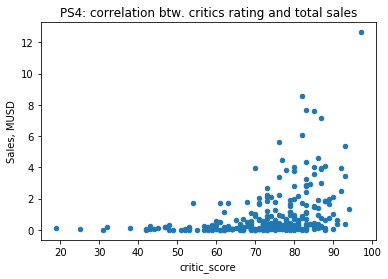

In [86]:
ps4.plot(x='critic_score',y='total_sales', kind ='scatter')

plt.title('PS4: correlation btw. critics rating and total sales')
plt.ylabel('Sales, MUSD');

In [87]:
print(ps4['critic_score'].corr(ps4['total_sales']))

0.37472657949977844


We chose _ps4_ as an example. The graphs and the Pearson correlation coefficients above show us, that the correlation btw. professional reviews and sales exists, but it is weak. 
    
The correlation btw. user reviews and sales is so weak, that it's better to say that in this case there is no correlation at all.

In [89]:
ps4.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17


In [104]:
gta = df[df["name"] == "Grand Theft Auto V"]

cod = df[df["name"] == "Call of Duty: Advanced Warfare"]

print(gta[["name", "platform", 'critic_score', 'user_score', "total_sales"]])

print(cod[["name", "platform", 'critic_score', 'user_score', "total_sales"]])

                    name platform  critic_score  user_score  total_sales
16    Grand Theft Auto V      PS3          97.0         8.2        21.05
23    Grand Theft Auto V     X360          97.0         8.1        16.27
42    Grand Theft Auto V      PS4          97.0         8.3        12.62
165   Grand Theft Auto V     XOne          97.0         7.9         5.47
1729  Grand Theft Auto V       PC          96.0         7.9         1.17
                                name platform  critic_score  user_score  \
92    Call of Duty: Advanced Warfare      PS4          83.0         5.7   
179   Call of Duty: Advanced Warfare     XOne          81.0         5.4   
255   Call of Duty: Advanced Warfare      PS3          78.0         4.8   
263   Call of Duty: Advanced Warfare     X360          78.0         4.9   
4735  Call of Duty: Advanced Warfare       PC          78.0         4.5   

      total_sales  
92           7.66  
179          5.26  
255          4.36  
263          4.28  
4735       

In [102]:
print(gta['critic_score'].corr(gta['total_sales']))

print(cod['critic_score'].corr(cod['total_sales']))

print(gta['user_score'].corr(gta['total_sales']))

print(cod['user_score'].corr(cod['total_sales']))

0.7060690579975042
0.7867389609892471
0.7711713252709759
0.9203772616092654


We are not sure, if we understood the task "Keeping your conclusions in mind, compare the sales of the same games on other platforms" correct, as far as the previous task was about _platforms_, not _games_. 

We just took two PS4 games where released on other platforms too and calculated the Pearson correlation coefficient for each of them. 

For both of this games corrlation btw. professional reviews and sales is very strong. For "Grand Theft Auto V" the correlation btw. user and professional reviews and sales is even a bit stronger. On the other hand for "Call of Duty: Advanced Warfare" this type of correlation is even stronger. 

If we want to compare sales of this games on different platforms, GTA V has the highest sales on PS3 and X360. 
CoD: Advanced Warfare  has the highest sales on PS4 and XOne. 

In [105]:
genres_df = df.groupby(['genre'])[['total_sales']].sum().sort_values(by = "total_sales", ascending=False).join(
    df.groupby('genre')[['name']].count())

genres_df.columns = ['total sales', 'number_of_games']

genres_df = genres_df.reset_index()
print(genres_df.tail(20))

           genre  total sales  number_of_games
0         Action       321.87              766
1        Shooter       232.98              187
2         Sports       150.65              214
3   Role-Playing       145.89              292
4           Misc        62.82              155
5       Platform        42.63               74
6         Racing        39.89               85
7       Fighting        35.31               80
8      Adventure        23.64              245
9     Simulation        21.76               62
10      Strategy        10.08               56
11        Puzzle         3.17               17


The small table in previous cell shows the revuenue range by genre of game. Action games are the clear favorite. Sport games and shooters are also very popular. 

The least popular genres are puzzles and strategies. 

### Step 3: Conclusion

We had done a really huge work in this step. 

We looked, how many games were released in different years and determined all the main periods of the game industry.. 

We explore the sales variety depending on platfrom, we founded the most popular platforms and looked how the sales were distributed over the years. We founded a typical life cycle of a game: release, very first years, maturity and fade. 

We build some prognoses for the next 2017 year; we build some graphs to better understand our data and found out, that user and professional reviews affect sales with weak correlation.

Finally we founded the most and the least popular game genres and discovered, that actions generates ca. 15 times more sales than strategies. 

## Step 4:  Create a user profile for each region

In [106]:
na_df = df.groupby(['platform'])[['na_sales']].sum().sort_values(by = "na_sales", ascending=False).join(
    df.groupby('platform')[['name']].count())

na_df.columns =  ["na_sales", "number_of_games"]
na_df = na_df.reset_index()
na_df["market_share"] = na_df["na_sales"]/na_df["na_sales"].sum() *100
print("Top 5 platforms in NA: ")
print(na_df.head())
print()

eu_df = df.groupby(['platform'])[['eu_sales']].sum().sort_values(by = "eu_sales", ascending=False).join(
    df.groupby('platform')[['name']].count())

eu_df.columns =  ["eu_sales", "number_of_games"]
eu_df = eu_df.reset_index()
eu_df["market_share"] = eu_df["eu_sales"]/eu_df["eu_sales"].sum() *100
print("Top 5 platforms in EU: ")
print(eu_df.head())
print()

jp_df = df.groupby(['platform'])[['jp_sales']].sum().sort_values(by = "jp_sales", ascending=False).join(
    df.groupby('platform')[['name']].count())

jp_df.columns =  ["jp_sales", "number_of_games"]
jp_df = jp_df.reset_index()
jp_df["market_share"] = jp_df["jp_sales"]/jp_df["jp_sales"].sum() *100

print("Top 5 platforms in JP: ")
print(jp_df.head())

Top 5 platforms in NA: 
  platform  na_sales  number_of_games  market_share
0      PS4    108.74              392     24.842933
1     XOne     93.12              247     21.274360
2     X360     81.66              186     18.656188
3      PS3     63.50              345     14.507322
4      3DS     38.20              303      8.727239

Top 5 platforms in EU: 
  platform  eu_sales  number_of_games  market_share
0      PS4    141.09              392     35.971241
1      PS3     67.81              345     17.288326
2     XOne     51.59              247     13.152997
3     X360     42.52              186     10.840578
4      3DS     30.96              303      7.893328

Top 5 platforms in JP: 
  platform  jp_sales  number_of_games  market_share
0      3DS     67.81              303     48.167353
1      PS3     23.35              345     16.586163
2      PSV     18.59              358     13.205001
3      PS4     15.96              392     11.336838
4     WiiU     10.88              115     

<div class="alert alert-info" role="alert">

We are calculated top 5 by sales, not by number of games. The Japan market is unique: 4 of rows in top 5 are Japan game platforms and Wii with humble 7.7 % on the 5th place. The Japan total market volume is the smallest of the three regions. 

In America the PS4 is the most popular plarform. Interesting, that only Xone and X360 are both american platformas in NA Top 5. The other three platforms are comming from Japan. 

There is no european games in EU top 5. Europeans play both Japan an US games with Japan PS4 on the 1st place.  

</div>

In [107]:
na_df2 = df.groupby(['genre'])[['na_sales']].sum().sort_values(by = "na_sales", ascending=False).join(
    df.groupby('genre')[['name']].count())

na_df2.columns =  ["na_sales", "number_of_games"]
na_df2 = na_df2.reset_index()
na_df2["market_share"] = na_df2["na_sales"]/na_df2["na_sales"].sum() *100
print("Top 5 genres in NA: ")
print(na_df2.head())
print()

eu_df2 = df.groupby(['genre'])[['eu_sales']].sum().sort_values(by = "eu_sales", ascending=False).join(
    df.groupby('platform')[['name']].count())

eu_df2.columns =  ["eu_sales", "number_of_games"]
eu_df2 = eu_df2.reset_index()
eu_df2["market_share"] = eu_df2["eu_sales"]/eu_df2["eu_sales"].sum() *100
print("Top 5 genres in EU: ")
print(eu_df2.head())
print()

jp_df2 = df.groupby(['genre'])[['jp_sales']].sum().sort_values(by = "jp_sales", ascending=False).join(
    df.groupby('genre')[['name']].count())

jp_df2.columns =  ["jp_sales", "number_of_games"]
jp_df2 = jp_df2.reset_index()
jp_df2["market_share"] = jp_df2["jp_sales"]/jp_df2["jp_sales"].sum() *100

print("Top 5 genres in JP: ")
print(jp_df2.head())

Top 5 genres in NA: 
          genre  na_sales  number_of_games  market_share
0        Action    126.05              766     28.797606
1       Shooter    109.74              187     25.071394
2        Sports     65.27              214     14.911700
3  Role-Playing     46.40              292     10.600626
4          Misc     27.49              155      6.280414

Top 5 genres in EU: 
          genre  eu_sales  number_of_games  market_share
0        Action    118.13              NaN     30.117533
1       Shooter     87.86              NaN     22.400122
2        Sports     60.52              NaN     15.429722
3  Role-Playing     36.97              NaN      9.425592
4        Racing     20.19              NaN      5.147490

Top 5 genres in JP: 
          genre  jp_sales  number_of_games  market_share
0  Role-Playing     51.04              292     36.255150
1        Action     40.49              766     28.761188
2          Misc      9.20              155      6.535019
3      Fighting      7.

<div class="alert alert-info" role="alert"> 
    
The Japan is unique as usual, if we can say so: during EU and US top 4 genres are identical and only the 5th popular genre in EU/US differs, Japanese people preffer role-playing over the action games. Shooters are surprisingly not in top 5 in Japan. 

How can we explane the difference? It's hardly to find another explanation other than different peoples taste or may be some cultural/traditional preferences. 
</div>

And now we are going to check, if ESRB ratings affect sales in individual regions. 

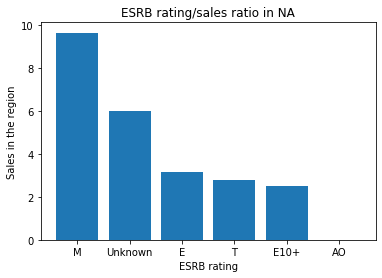

In [110]:
plt.bar(df['rating'], df['na_sales'])

plt.title('ESRB rating/sales ratio in NA')
plt.xlabel('ESRB rating')
plt.ylabel('Sales in the region')

plt.show();

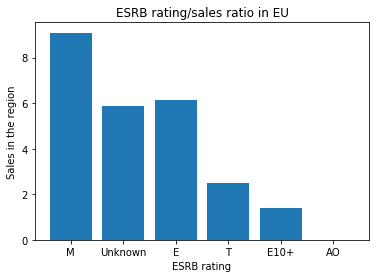

In [111]:
plt.bar(df['rating'], df['eu_sales'])

plt.title('ESRB rating/sales ratio in EU')
plt.xlabel('ESRB rating')
plt.ylabel('Sales in the region')

plt.show();

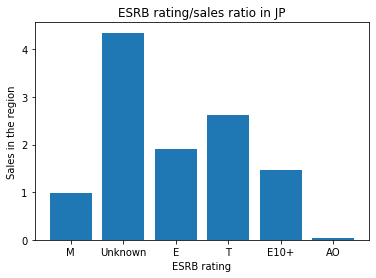

In [112]:
plt.bar(df['rating'], df['jp_sales'])

plt.title('ESRB rating/sales ratio in JP')
plt.xlabel('ESRB rating')
plt.ylabel('Sales in the region')

plt.show();

Sales in EU and Nord America in dependence of ESRB rating looks very similar. The "Everybody" games share in EU only seems to be higher than in the NA. 

Japan market is as always special: in this country percent of games with "Mature" rating is much lower and with "Teen"/"Everybody 10+" is much higher than in the EU/NA.  We can assume, that share of adults how buying games in Japan is lower, than in EU/NA. 

### Step 4: Conclusion

In this short step we investigated some characteristics of regional markets. The main conclution we can draw is japan market is very specific while american and european markets are very similar in all the aspects we have been considering. 

## Step 5:  Testing of hypotheses

Let's check, if average user ratings of the Xbox One and PC platforms are the same.

We formulate the null hypothese as `Average user ratings of the Xbox One and PC platforms are the same` and the alternative one as `Average user ratings of the Xbox One and PC platforms does (signuficantly) differ`.

We use an alpha of 0.05 as a standart 5% confidence threshold.

We are going to compare an average user rating of the Xbox One with the similar figures calculated PC users.

In [118]:
sample_xbox = df.groupby(['platform'])['user_score'].get_group('XOne')
sample_pc = df.groupby(['platform'])['user_score'].get_group('PC')

xbox_mu = sample_xbox.mean()
pc_mu = sample_pc.mean()
xbox_sd = sample_xbox.std()
pc_sd = sample_pc.std()

print('Xbox µ', xbox_mu)
print()
print('PC µ', pc_mu)
print()
print('Xbox SD', xbox_sd)
print()
print('PC SD', pc_sd)

Xbox µ 5.101295546558704

PC µ 5.234444444444444

Xbox SD 2.8102379506238306

PC SD 2.7712573637045197


In [139]:
shapiro_test = stats.shapiro(sample_xbox)
print(shapiro_test)

shapiro_test2 = stats.shapiro(sample_pc)
print(shapiro_test2)

(0.8495548963546753, 9.060059221409865e-15)
(0.8737955093383789, 1.7766671814301027e-11)



<div class="alert alert-info" role="alert">

Since p > 0.05 for both data sets, they both conform to the normality criterion.
    
</div>

In [127]:
st.levene(sample_xbox, sample_pc, center= 'mean')

LeveneResult(statistic=0.003998761219482251, pvalue=0.9496078835105561)

<div class="alert alert-info" role="alert">

pvalue is bigger than 0.05 so the datasets conform to the variance criterion.
    
</div>

In [68]:
pc_sample = df[df['platform'] == 'PC']

print(len(pc_sample))

pc_sample = pc_sample[pc_sample["user_score"] != 0]

print(len(pc_sample))

776
643


In [69]:
xbox_sample = df[df['platform'] == 'XOne']

print(len(xbox_sample))

pc_sample = xbox_sample[xbox_sample["user_score"] != 0]

print(len(xbox_sample))

247
247


In [70]:
user_score_pc = pc_sample['user_score'].tolist()
user_score_xbox = xbox_sample['user_score'].tolist()

res = st.ttest_ind(user_score_pc, user_score_xbox)
print(res)

Ttest_indResult(statistic=5.0032745939156476, pvalue=8.104509356270609e-07)


With very small pvalue 0.00000081 < 0.05 we got the information that our null hypothesis `Average user ratings of the Xbox One and PC platforms are the same` should be rejected.

Let's check an another hypothesis.

We formulate the null hypothese as 'Average user rating for the Action and Sports genres are not (signuficantly) different' and the alternative one as 'Average user ratings for the Action and Sports genres are (signuficantly) different'. 

We use an alpha of 0.05 as a standart 5% confidence threshold. We are goint to compare an average user rating of action games with the similar figures calculated for sport games.

In [114]:
sample_action = df.groupby(['genre'])['user_score'].get_group('Action')
sample_sport = df.groupby(['genre'])['user_score'].get_group('Sports')

action_mu = sample_action.mean()
sport_mu = sample_sport.mean()
action_sd = sample_action.std()
sport_sd = sample_sport.std()

print('Action games µ', action_mu)
print()
print('Sport games µ', sport_mu)
print()
print('Action games SD', action_sd)
print()
print('Sport games SD', sport_sd)

Action games µ 3.7109399477806786

Sport games µ 3.951401869158878

Action games SD 3.4331723783398287

Sport games SD 2.726216297825927


In [128]:
st.levene(sample_action, sample_sport, center= 'mean')

LeveneResult(statistic=88.91701715312665, pvalue=2.892701716900223e-20)

In [130]:
sport_sample = df[df['genre'] == 'Sports']

print(len(sport_sample))

sport_sample = sport_sample[sport_sample["user_score"] != 0]

print(len(sport_sample))

214
162


In [131]:
sample_action = df[df['genre'] == 'Action']

print(len(action_sample))

action_sample = action_sample[action_sample["user_score"] != 0]

print(len(action_sample))

766
438


In [142]:
action_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438 entries, 16 to 16690
Data columns (total 12 columns):
name               438 non-null object
platform           438 non-null object
year_of_release    438 non-null int16
genre              438 non-null object
na_sales           438 non-null float64
eu_sales           438 non-null float64
jp_sales           438 non-null float64
other_sales        438 non-null float64
critic_score       438 non-null float64
user_score         438 non-null float64
rating             438 non-null object
total_sales        438 non-null float64
dtypes: float64(7), int16(1), object(4)
memory usage: 41.9+ KB


In [145]:
shapiro_test3 = stats.shapiro(sample_sport)
print(shapiro_test3)

shapiro_test4 = stats.shapiro(sample_action)
print(shapiro_test4)

(0.8980890512466431, 6.838900973304973e-11)
(0.7905890345573425, 3.0914666355439337e-30)


<div class="alert alert-info" role="alert">

Since p < 0.05 for both datasets, they not conform to the normality criterion. And we can not perform Levene test. We'll try with Bartlett. 
    
</div>

In [148]:
bartlett(sample_sport, sample_action)

BartlettResult(statistic=16.159771936325782, pvalue=5.8217442157997724e-05)

<div class="alert alert-info" role="alert">

pvalue is much smaller than 0.05 so the datasets is not conform to the variance criterion. We are going to use False parameter of equal_var. 
    
</div>

In [144]:
user_score_sport = sport_sample['user_score'].tolist()
user_score_action = action_sample['user_score'].tolist()

res = st.ttest_ind(user_score_sport, user_score_action, equal_var = False)
print(res)

Ttest_indResult(statistic=-7.967694601665843, pvalue=4.9340304287866644e-14)


With very small pvalue  < 0.05 we got the information that our null hypothesis 'Average user rating for the Action and Sports genres are not (signuficantly) different' should be rejected.

### Step 5: Conclusion

In this step we performed some statistical analysis of out data. Due the calculation we rejected two hypothesis we had.

## Step 6:  General conclusion

In this project we performed an exhaustively research on video games sales data of the online store Ice and some historical data on game sales, ratings and reviews were available from open sources. 

The Ice's commercial department wanted to identify patterns that determine whether a game succeeds or not. This will allow company to spot potential big winners and plan advertising campaigns.

Data we got initially was incomplete. We used one more publicly availible dataset to fill in a significant part of the missing information. We successfully merged both datasets and preprocessed data for our further analysis. 

During the analysis phase we looked, how many games were released in different years and determined all the main periods of the game industry in 1980-2016. We founded a typical life cycle of a game: release, very first years, maturity and fade and how long it typically is: ususally less than 10 years with 3-5 years of peak time. 

We explore the sales variety depending on platfrom, we founded the most popular platforms and looked how the sales were distributed over the years. 

This data allows us to made a conclusion, that games platforms like PS4, XOne and WiiU with high probability will show very high sales during the next 2017 year. 

We also founded the most popular game genres: in EU/NA thats are action and sport games, in Japan - role-playing games. Among others we discovered, that action games generates ca. 15 times more sales revenue than strategies (the least popular genre globally).

We created a user profile for each of three main regions - North America, EU and Japan; we considered some specific characteristics of regional markets. The main conclution we could draw is that japan market is specific one while american and european markets are very similar in all the aspects we had been considering.

Finally we performed some statistical analysis of out data. We rejected two hypotesis, that average user ratings of the Xbox One and PC platforms and that average user ratings for the Action and Sports genres are the same. 

Obtained date can be used by the commercial department to determine an advertisement strategy and to adjust the advertisement budget for the next year.